## Assignment 2: Neural Machine Translation

In this assignment, we will implement an encoder-decoder neural network for the task of machine translation.

![img](https://lena-voita.github.io/resources/lectures/seq2seq/general/enc_dec_simple_rnn-min.png)

We'll translate short image descriptions (without using the images themselves) from English to German.
This task shows the scale of machine translation while not requiring you to train your model for weeks if you don't use GPU.

### ❗  Contributions

**Please add a brief 1-2 sentence statement explaining the contributions of each group member (only refer to group members by UUNs):**


s2141524 and s2196926 worked on this assignment together


## Setup

In [ ]:
# install dependencies
!pip3 install torch pandas nltk matplotlib
!pip3 install subword-nmt &> log
!wget https://gist.githubusercontent.com/saparina/45e4e8af5cb6b57c786ca246e1c75530/raw/b7d06c8a570b68ef22c9fc2f627bbb8a54f4cf27/vocab.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
source_lang = "en"
target_lang = "de"
splits = ['train', 'val', 'test']

data = {}
for split in splits:
    file_name = f"{split}.jsonl"
    df = pd.read_json(f"hf://datasets/bentrevett/multi30k/{file_name}", lines=True)
    data[split] = df

for split, df in data.items():
    df['de'].to_csv(f"{split}.de", index=False, header=False, mode='w')
    df['en'].to_csv(f"{split}.en", index=False, header=False, mode='w')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## 1. Data Preprocessing (5 points)

Before we get to the architecture, it is important to preprocess the data. For this assignment, the preprocessing has already been done for you.

Here's the process:
1. The data is tokenized with [WordPunctTokenizer](https://www.nltk.org/api/nltk.tokenize.regexp.html#nltk.tokenize.regexp.WordPunctTokenizer)  which splits text based on word boundaries and punctuation.

2. Then we apply [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt). The algorithm starts with a character-level tokenization and then iteratively merges most frequent pairs for N iterations. This results in frequent words being merged into a single token and rare words split into syllables or even characters.



In [ ]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
for lang in [source_lang, target_lang]:
    for split in splits:
        with open(split + '.tok.' + lang, 'w') as f_src:
            for line in open(split + '.' + lang):
                f_src.write(tokenize(line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in [source_lang, target_lang]:
    learn_bpe(open('./train.tok.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    for split in splits:
        with open(split + '.bpe.' + lang, 'w') as f_out:
            for line in open(split + '.tok.' + lang):
                f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:07<00:00, 1080.03it/s]


### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're will use them when we feed training data into model or convert output matrices into words.

In [ ]:
train_inp = np.array(open('train.bpe.' + source_lang, encoding='utf-8').read().split('\n'))
train_out = np.array(open('train.bpe.' + target_lang, encoding='utf-8').read().split('\n'))

val_inp   = np.array(open('val.bpe.' + source_lang, encoding='utf-8').read().split('\n'))
val_out   = np.array(open('val.bpe.' + target_lang, encoding='utf-8').read().split('\n'))

test_inp = np.array(open('test.bpe.' + source_lang, encoding='utf-8').read().split('\n'))
test_out = np.array(open('test.bpe.' + target_lang, encoding='utf-8').read().split('\n')) # UPDATE 2025-02-26: Previous version incorrectly computed test BLEU score, now fixed

for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: " two young , white males are outside near many bushes ."
out: zwei junge weiße männer sind im freien in der nähe viel@@ er büsche .

inp: several men in hard hats are operating a giant pulley system .
out: mehrere männer mit schutzhelmen bedienen ein an@@ tri@@ eb@@ s@@ rad@@ system .

inp: a little girl climbing into a wooden playhouse .
out: ein kleines mädchen klettert in ein spiel@@ haus aus holz .



In [ ]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

print("Source vocab size", len(inp_voc))
print("Target vocab size", len(out_voc))

Source vocab size 7202
Target vocab size 7679


In [ ]:
# Here's how you cast lines into ids and backwards.
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
[np.str_('men play baseball .'), np.str_('a child in a swing .'), np.str_('a man playing cricket'), np.str_('a car is in the water'), np.str_('a man climbs a rock .')]

words to ids (0 = bos, 1 = eos):
tensor([[   0, 3659, 4416,  544,   22,    1,    1,    1],
        [   0,   65, 1166, 2969,   65, 6002,   22,    1],
        [   0,   65, 3568, 4424, 1513,    1,    1,    1],
        [   0,   65, 1010, 3065, 2969, 6186, 6902,    1],
        [   0,   65, 3568, 1255,   65, 4901,   22,    1]])

back to words
['men play baseball .', 'a child in a swing .', 'a man playing cricket', 'a car is in the water', 'a man climbs a rock .']


Draw source and translation length distributions to estimate the scope of the task.

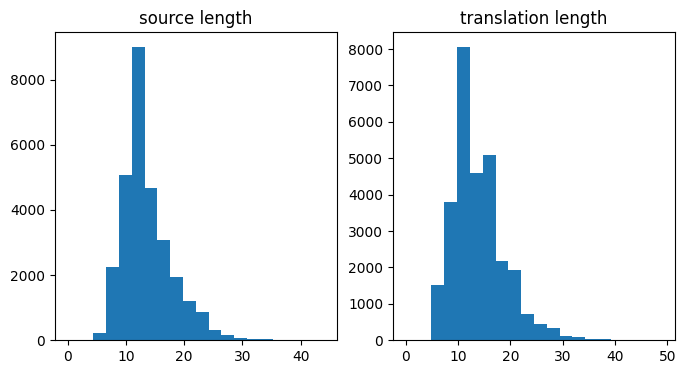

In [ ]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### ❓ Question (5 points)

What tokens correspond to indices 0 and 1 in vocabulary? What roles do they play? Is it possible to train a model without them, and if so, how?

Indices 0 and 1 correspond to the Beginning of Sequence(BOS) token and End of Sequence(EOS) token respectively. The BOS token indicates the beginning of a sentence and the EOS token indicates when a sentence has ended. The combination of the 2 tokens help the decoder know when to initialize and stop translation. While it is possible to train a model without them, this would require the data provided to have sequence boundaries so that the model knows when to start and stop the translation.*<Your answer in 3-5 sentences>*

## 2. Basic Encoder-Decoder Model (15 points)

The code below contains a template for a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything. You need to implement ```decode_step``` (5 points).

In [ ]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__() # initialize base class to track sub-layers, parameters, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        # compute embeddings
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        # sequentially applying a GRU cell to each input
        # (this logic is hidden in the GRU implementation)
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]

        # note: enc0 works on a batch level, so we will need to process padding!
        # last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        # create an initial hidden vector for the decoder
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """

        ### YOUR CODE
        prev_gru0_state = prev_state[0]

        prev_emb = self.emb_out(prev_tokens)

        new_dec_state = self.dec0(prev_emb, prev_gru0_state)

        output_logits = self.logits(new_dec_state)
        ### END OF YOUR CODE

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step, use for training"""
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            # note: we use the reference labels here (out_tokens)
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version), use for inference """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            # note: we use the predicted tokens
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

In [ ]:
# debugging area
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list), type(h1)
assert len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [ ]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
afri@@ fußgängerbrücke teenagerin musku@@ football@@ pfeil orche@@ stie@@ y lackiert lackiert pre@@ afroamerikan@@ dribbelt stellt tzt winterjacke sportlerin ron stift aufhat trainieren etwas schrif@@ gür@@
afri@@ tte richter richter repariert vorbei ” suchen haltung verkehrt ara@@ trüben alls spielend akkordeon@@ packen steu@@ noti@@ lö@@ pustet übung neben@@ coca ehnt promenade
afri@@ wildwasser@@ 8@@ schleife rennt schnau@@ telef@@ telef@@ gegend hier ganzen oberteilen felsbrocken tro@@ handschuhe lächelndes 4@@ hemd@@ anzüge babyschaukel unterhaltung kreide koch@@ tanzfläche skolben


### Training loss (5 points)

Our training objective is:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

In [ ]:

def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    ### YOUR CODE
    model_outputs = model(inp, out)
    ### END OF YOUR CODE

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    ### YOUR CODE
    log_probs = F.log_softmax(model_outputs, dim=-1)
    ### END OF YOUR CODE

    # log-probabilities of correct outputs, [batch_size, out_len]
    ### YOUR CODE
    log_probs_correct = torch.sum(log_probs * targets_1hot, dim=-1)
    ### END OF YOUR CODE
    # ^-- this will select the probability of the actual next token.

    # average cross-entropy over tokens where mask == True
    ### YOUR CODE
    loss = -torch.sum(log_probs_correct * mask) / torch.sum(mask)
    ### END OF YOUR CODE
    return loss

In [ ]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.6, rtol=0.01, atol=0.01), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

print("Test passed!")

Loss: tensor(7.6071, device='cuda:0', grad_fn=<DivBackward0>)
Test passed!


### Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    Note: if you're serious about reporting your results, use https://pypi.org/project/sacrebleu
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [ ]:
compute_bleu(model, val_inp, val_out)

0.004044872108229374

### Training loop (2+3 points)

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [ ]:
from IPython.display import clear_output
from tqdm import tqdm, trange

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [ ]:
print("Model size", sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6, "M")

Model size 2.108479 M


Implement training loop (2 points):

In [ ]:
def train(model, opt, batch_size, num_steps=20000, save_path="best_basemodel.pth"):
    metrics = {'train_loss': [], 'dev_bleu': [] }
    best_bleu = 0.0
    for _ in trange(num_steps):
        step = len(metrics['train_loss']) + 1
        batch_ix = np.random.randint(len(train_inp), size=batch_size)
        batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
        batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

        ### YOUR CODE
        loss_t = compute_loss(model, batch_inp, batch_out)

        opt.zero_grad()
        loss_t.backward()
        opt.step()
        ### END OF YOUR CODE

        metrics['train_loss'].append((step, loss_t.item()))

        if step % 100 == 0:
            dev_bleu = compute_bleu(model, val_inp, val_out)
            metrics['dev_bleu'].append((step, dev_bleu))

            if dev_bleu > best_bleu:
                best_bleu = dev_bleu
                torch.save(model.state_dict(), save_path)

            clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
    return metrics

Train your model (3 points):

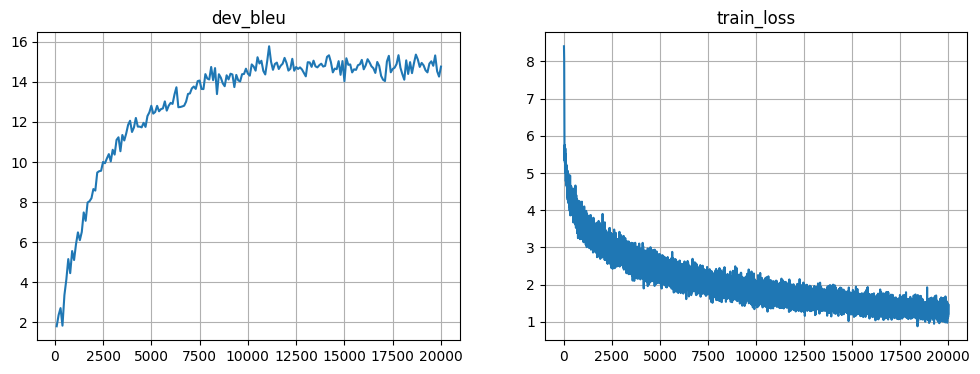

Mean loss=1.325


100%|██████████| 20000/20000 [10:25<00:00, 31.97it/s]


In [ ]:
metrics = train(model, opt, batch_size)
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [ ]:
bleu_scores = np.mean(metrics['dev_bleu'][-10:], axis=0)[1]
assert bleu_scores > 13, f"BLEU score should be > 13 on average, you got {bleu_scores}"

In [ ]:
model.load_state_dict(torch.load("best_basemodel.pth", weights_only=True))
model.to(device)

final_bleu_score = compute_bleu(model, test_inp, test_out)  # UPDATE 2025-02-26: Previous version incorrectly computed test BLEU score, now fixed
f"BLEU score on the test set: {final_bleu_score:.3}"

'BLEU score on the test set: 14.5'

## 3. Encoder-Decoder Model with Attention (15 points)

In this section we want you to improve over the basic model by implementing a simple attention mechanism.

This is gonna be a two-parter: building the __attention layer__ and using it for an __attentive seq2seq model__.

### Attention layer (6 points)

Here you will have to implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute scores with a 2-layer neural network:
$$s_t = linear_{out}(tanh(linear_{enc}(h^e_t) + linear_{dec}(h^d)))$$
* Get probabilities from scores:
$$ p_t = {{e ^ {s_t}} \over { \sum_\tau e^{s_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__ (attention context vector):
$$ c = \sum_t p_t \cdot h^e_t $$

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size, activ=torch.tanh):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.name = name
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity

        # create trainable paramteres
        self.linear_enc = nn.Parameter(torch.zeros(self.enc_size, self.hid_size), requires_grad=True)
        self.linear_dec = nn.Parameter(torch.zeros(self.dec_size, self.hid_size), requires_grad=True) # you will need a couple of these
        self.linear_out = nn.Parameter(torch.zeros(self.hid_size, 1), requires_grad=True)

        torch.nn.init.xavier_uniform_(self.linear_enc.data)
        torch.nn.init.xavier_uniform_(self.linear_dec.data)
        torch.nn.init.xavier_uniform_(self.linear_out.data)


    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        # Compute scores
        ### YOUR CODE
        dec_expanded = dec.unsqueeze(1)

        enc_proj = torch.matmul(enc, self.linear_enc)
        dec_proj = torch.matmul(dec_expanded, self.linear_dec)

        scores = torch.matmul (self.activ(enc_proj + dec_proj), self.linear_out.squeeze(-1) )
        ### END OF YOUR CODE

        # Apply mask - if mask is 0, scores should be -inf or -1e9
        # You may need torch.where
        ### YOUR CODE
        socres = torch.where(inp_mask > 0, scores, torch.tensor(-1e9, device=scores.device))
        ### END OF YOUR CODE

        # Compute attention probabilities (softmax)
        ### YOUR CODE
        probs = torch.softmax(scores, dim=-1)
        ### END OF YOUR CODE

        # Compute attention response using enc and probs
        ### YOUR CODE
        attn = torch.sum(enc * probs.unsqueeze(-1), dim=1)
        ### END OF YOUR CODE

        return attn, probs

In [ ]:
# debugging
batch_size = 32
ninp = 7
enc_size = 64
dec_size = 128
layer = AttentionLayer("", enc_size, dec_size, 72)
attn, probs = layer(torch.rand(batch_size, ninp, enc_size), torch.rand(batch_size, dec_size), torch.rand(batch_size, ninp) > .5)
assert attn.shape == (batch_size, enc_size), attn.shape
assert probs.shape == (batch_size, ninp), probs.shape # if you have redundant dimensions of size 1, you might find torch.squeeze useful

### Seq2seq model with attention (6 points)

You can now use the attention layer to build a network. The simplest way to implement attention is to use it in decoder phase:
![img](https://lena-voita.github.io/resources/lectures/seq2seq/attention/bahdanau_model-min.png)

- On every step, use __previous__ decoder state to obtain attention response.
- Then feed concat this response to the inputs of next attention layer.

The key implementation detail here is __model state__. Any tensor added into the list of `encode` outputs list will be available for use during each `decode` step. You should include:
* Last RNN hidden states (as in basic model)
* The whole sequence of encoder outputs (to attend to) and mask
* Attention response and attention probabilities (to visualize)

In [ ]:
class AttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. Inherit all functions and params of BasicModel """
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        super().__init__(inp_voc, out_voc, emb_size=emb_size, hid_size=hid_size)
        self.attention = AttentionLayer(name, hid_size, hid_size, attn_size)
        self.dec0 = nn.GRUCell(emb_size + attn_size, hid_size)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        ### YOUR CODE
        inp_emb = self.emb_inp(inp)
        enc_seq, _ = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        ### END OF YOUR CODE

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)

        # apply attention layer from initial decoder hidden state
        inp_mask = self.inp_voc.compute_mask(inp)

        ### YOUR CODE
        first_attn_response, first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)
        ### END OF YOUR CODE

        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor

        first_state = [dec_start, enc_seq, inp_mask, first_attn_response, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        prev_gru0_state, enc_seq, inp_mask, prev_attn_response, prev_attn_probas = prev_state

        ### YOUR CODE
        prev_tokens_emb = self.emb_out(prev_tokens)
        concat_inp = torch.cat([prev_tokens_emb, prev_attn_response], dim=-1)
        new_dec_state = self.dec0(concat_inp, prev_gru0_state)
        output_logits = self.logits (new_dec_state)

        attn_response, attn_probas = self.attention(enc_seq, new_dec_state, inp_mask)
        ### END OF YOUR CODE

        return [new_dec_state, enc_seq, inp_mask, attn_response, attn_probas], output_logits


### Training attentive model (3 points)

Please reuse the infrastructure you've built for the basic model.

In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel("model", inp_voc, out_voc, hid_size=128, attn_size=128).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

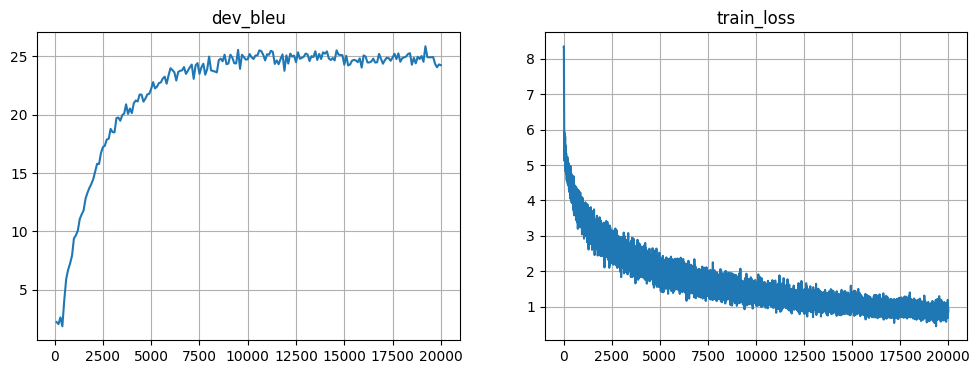

Mean loss=0.887


100%|██████████| 20000/20000 [21:33<00:00, 15.46it/s]


In [ ]:
metrics = train(model, opt, batch_size, save_path="best_attentivemodel.pth")

In [ ]:
model.load_state_dict(torch.load("best_attentivemodel.pth", weights_only=True))
model.to(device)

final_bleu_score = compute_bleu(model, test_inp, test_out)  # UPDATE 2025-02-26: Previous version incorrectly computed test BLEU score, now fixed
f"BLEU score on the test set: {final_bleu_score:.3}"

'BLEU score on the test set: 23.8'

### ❓ Question

Compare the BLEU scores of the attentive model and the basic model you trained in the previous section. Which one performs better, and why?

BLEU score on basic model is 14.5 and BLEU score on attentive model is 23.8. The significantly higher BLEU score on the attentive model can be explained as the attention layer in the attentive model allows for the decoder to focus on the most relevant words, allowing for more context-aware decoding. Also the basic model compresses the entire input sentence into a single fixed-sized vector for decoding as opposed to the attentive model which dynamically decodes different parts of the input allowing for better performance on longer sequences. *<Your answer in 1-3 sentences>*

## 4. Analyzing NMT (10 points)

### Translation Analysis (4 points)

Let's explore how the model we trained translates:


In [ ]:
for inp_line in test_inp[:5]:
    trans_line, _ = model.translate_lines([inp_line])
    print(inp_line)
    print(trans_line)
    print()

a man in an orange hat starring at something .
['ein mann mit einem orangefarbenen hut beobachtet etwas .']

a boston terrier is running on lush green grass in front of a white fence .
['ein fan läuft auf einer grünen grünen wiese vor einem weißen zaun .']

a girl in karate uniform breaking a stick with a front kick .
['ein mädchen in uniform geht einen weg mit einem zug .']

" five people wearing winter jackets and helmets stand in the snow , with snow@@ mobil@@ es in the background ."
['fünf menschen in winter@@ jacken und mit helmen stehen mit schnee@@ mobil im schnee .']

people are fixing the roof of a house .
['menschen fahren am dach eines hauses .']



### ❓ Questions

1. Analyze the types of errors your model makes.  You may use any external translator (e.g., Google Translate) to translate your German predictions back to English to better understand their meaning.

The results show lexical errors (e.g "starring" to "watching"), and named entity errors, with incorrect subject substitutions ("boston terrier" "fan"). Grammatical inconsistencies in the translations lead to awkward phrasing and number mismatches, highlighting challenges in morphological agreement and syntax handling in NMT systems.

2. What can help improve these translations?

We believe that improving the search from using greedy to a beam search in the decoder will allow it to further explore different paths and choose a sequence with a higher overall probability, which often results in more accurate and fluent translations by avoiding early commitment to suboptimal choices.

### Visualizing model attention (6 points)

You can validate your model by visualizing its attention weights. We provided you with a function that draws attention maps.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_attention(inp_line, translation, probs):
    """ Visualize attention weights with a black background and white squares """
    # Tokenize input and translation
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.set_facecolor("black")
    cax = ax.matshow(probs[::-1], cmap='gray')

    color_bar = fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

    ax.set_xticks(np.arange(len(inp_tokens)))
    ax.set_xticklabels(inp_tokens, rotation=45, ha='left', rotation_mode='anchor')

    ax.set_yticks(np.arange(len(trans_tokens)))
    ax.set_yticklabels(trans_tokens[::-1])


    ax.tick_params(axis='both', which='both', length=0)
    ax.spines[:].set_visible(False)

    plt.show()

In [ ]:
trans, states = model.translate_lines(test_inp[:5])

# select attention probs from model state
# attention_probs below must have shape [batch_size, translation_length, input_length], extracted from states
# e.g. if attention probs are at the end of each state, use np.stack([state[-1] for state in states], axis=1)

### YOUR CODE
attention_probs = np.stack([state[-1].detach().cpu().numpy() for state in states], axis=1)
### END OF YOUR CODE

In [ ]:
# Check for all examples and all translation steps
assert np.allclose(attention_probs.sum(axis=2), 1.0, atol=1e-4), "Attention probabilities do not sum to 1!"

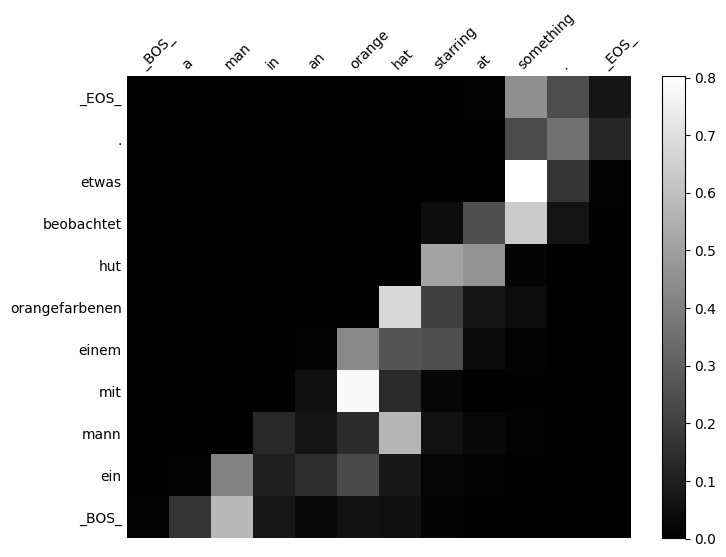

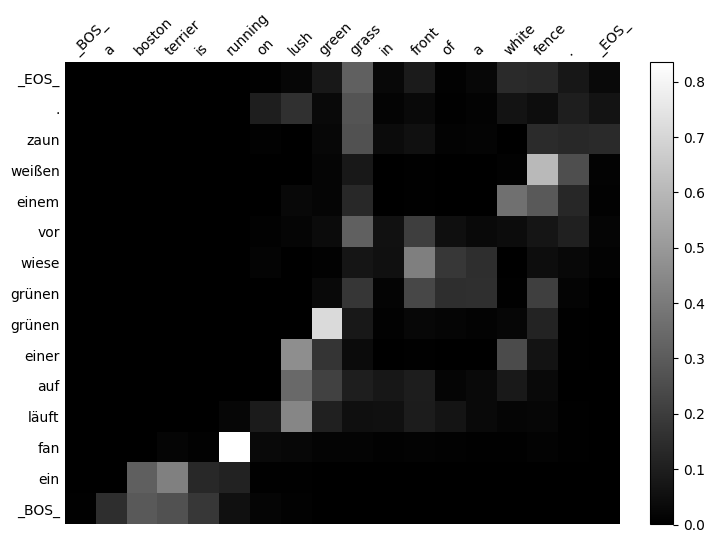

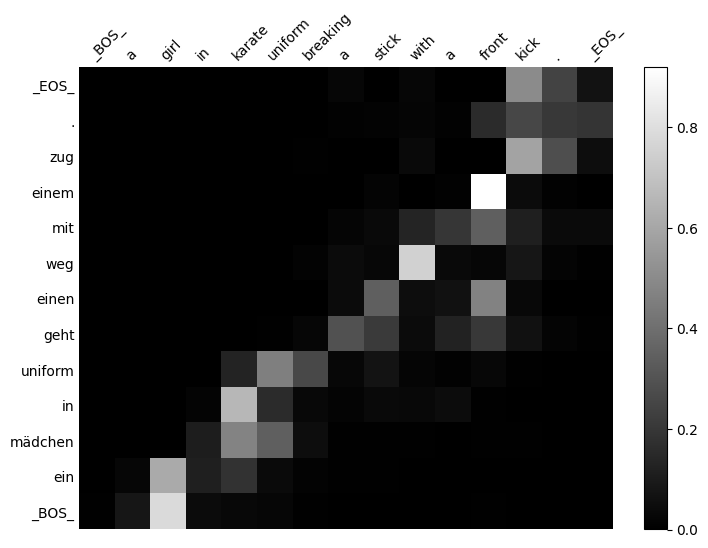

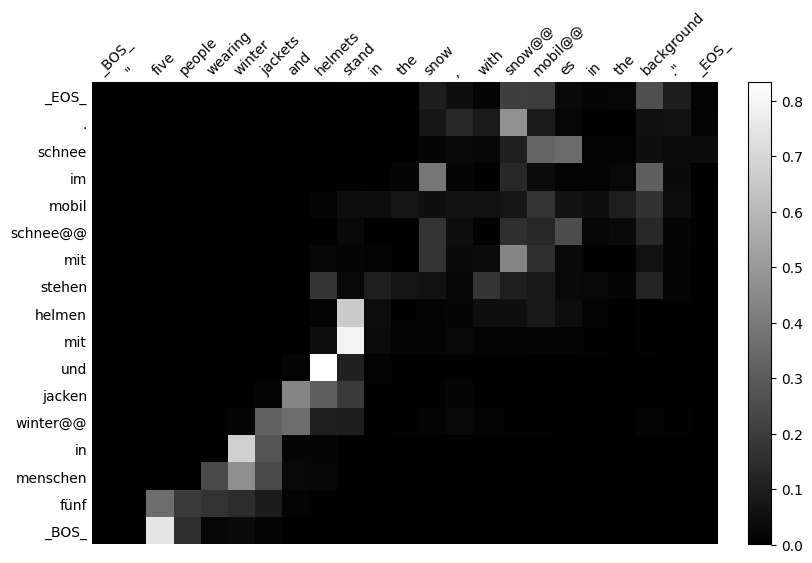

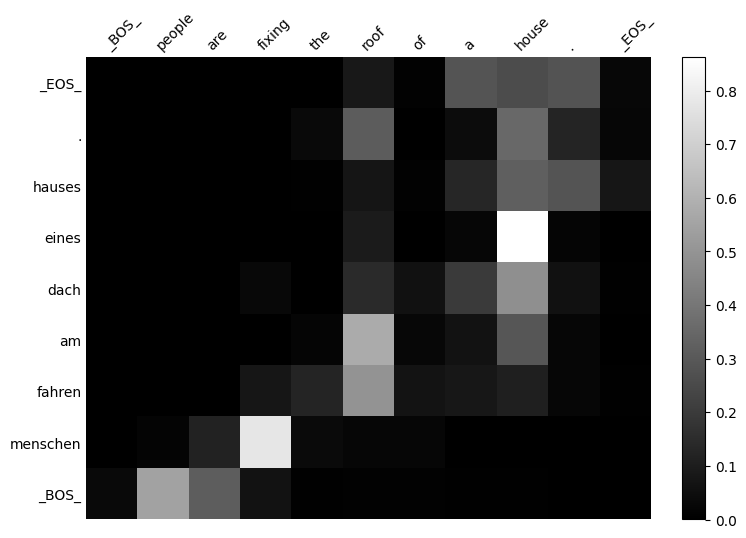

In [ ]:
for i in range(5):
    draw_attention(test_inp[i], trans[i], attention_probs[i])
# Does it look fine already? don't forget to save images!

### ❓ Question

Interpret how attention works:

Each row in the heatmap corresponds to a target token, and the intensity of the white squares indicates how much weight the model assigns to each source token when generating that target token. It reveals which parts of the input are most influential for each output word, showing that the decoder focuses on different parts of the input rather than relying on a single, fixed context vector. This also confirms that the decoder learns to align each output token to relevant parts of the input sentence, but the final choice of output token can still lead to mistranslation.